## Projekt - próba przewidzenia parametru $R_0$ przy użyciu uczenia maszynowego

#### Autorzy: Łukasz Eckert 132218, Damian Horna 132240

### 1. Wprowadzenie

Model SEIRD to tzw. compartmental model wykorzystywany w celu modelowania
rozwoju epidemii. W modelu tym populacja jest podzielona na kilka grup, które opiszemy
poniżej. Skrót SEIRD rozwija się następująco:
* S - Susceptible - liczba osób podatnych na zachorowanie
* E - Exposed - liczba osób, u których choroba jest w stadium inkubacji
* I - Infectious - liczba osób, które rozprzestrzeniają chorobę
* R - Recovered - liczba osób, które wyzdrowiały
* D - Dead - liczba osób, które zmarły

![title](img/seird.png)

Obserwacje w tym modelu przepływają pomiędzy odpowiednimi bloczkami, proces ten można przedstawić za pomocą następujących równań różniczkowych:

![eq](img/equations.png)

Gdzie:
* N - całkowita populacja
* $S(t)$ - liczba osób podatnych (susceptible) do dnia t
* $E(t)$ - lliczba osób, u których choroba jest w stadium inkubacji do dnia t
* $I(t)$ - liczba osób zainfektowanych do dnia t
* $R(t)$ - liczba osób, które wyzdrowiały do dnia t
* $D(t)$ - liczba osób, które zmarły do dnia t
* $\beta$ - ozcekiwana liczba osób, którą zainfekowana osoba zaraża każdego dnia
* $D$ - liczba dni, przez które zainfekowana osoba może zarażać
* $\gamma$ - proporcja zainfekowanych, którzy zdrowieją każdego dnia ($\gamma = 1/D$)
* $R_0$ - łączna liczba osób, którą zainfekowana choroba zaraża ($R_0 = \beta / \gamma$)
* $\delta$ - długość okresu inkubacji
* $\alpha$ - współczynnik śmiertelności
* $\rho$ - tempo umieralności (=1/liczba dni od zainfekowania do śmierci)

## 2. Wygenerowanie sztucznego zbioru danych

### 2.1. Pojedyncza symulacja 

In [7]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

Na początku wygenerujemy proste dane z modelu SEIRD. Model, który opisuje założoną przez nas rzeczywistość mozna opisać poniższymi równaniami różniczkowymi:

In [8]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

Ustawiamy parametry początkowe symulacji:

In [9]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
R_0 = 5.0
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
alpha = 0.2  # 20% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [10]:
t = np.linspace(0, 100, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

Przykładowy przebieg symulowanej epidemii

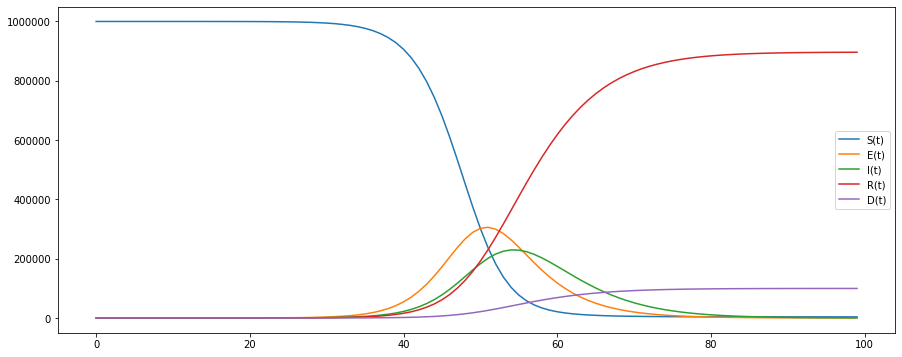

In [15]:
plt.figure(figsize=(15,6))
plt.plot(S, label='S(t)')
plt.plot(E, label='E(t)')
plt.plot(I, label='I(t)')
plt.plot(R, label='R(t)')
plt.plot(D, label='D(t)')
plt.legend()

Wygenerowane dane prezentują symulowany przebieg epidemii w okresie stu dni przy założonych warunkach początkowych i współczynnikach $\alpha, \beta, \gamma, \delta, \rho$

### 2.2. Wygenerowanie całego zbioru

Generujemy zbiór zakładając początkową populację 60 mln (rozmiar populacji Włoch) na przestrzeni 46 dni z różnymi parametrami symulacji (jak poniżej).

In [16]:
from tqdm import tqdm
N=60e6 # populacja - ustawiamy ją w ten sposób, aby odpowiadała danym z Włoch
D_vals = np.arange(4,10,1) # liczba dni, podczas których zainfekowany zaraża
delta_vals = 1/np.arange(5,15,1) # 1/długość okresu inkubacji w dniach
R_0_vals = np.arange(2,5,0.25) # oczek. liczba osób, które zostaną zarażone przez jednego zainfekowanego
alpha_vals = np.arange(0.02, 0.2, 0.02) # wsp. śmiertelności
rho_vals = 1/np.arange(9,20,1) # tempo umieralności (1 / liczba dni do śmierci)
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

X = []
y = []

for D in tqdm(D_vals):
    for delta in delta_vals:
        for R_0 in R_0_vals:
            for alpha in alpha_vals:
                for rho in rho_vals:
                    gamma = 1.0/D
                    beta = R_0 * gamma
                    t = np.linspace(0, 46, 46) # Grid of time points (in days)
                    y0 = S0, E0, I0, R0, D0 # Initial conditions vector

                    # Integrate the SIR equations over the time grid, t.
                    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
                    #S, E, I, R, D = ret.T
                    X.append(ret.T)
                    y.append([beta, gamma, delta, alpha, rho])

100%|██████████| 6/6 [00:53<00:00,  8.86s/it]


In [17]:
X = np.array(X)
y = np.array(y)

In [18]:
np.save('X.npy', X)
np.save('y.npy', y)

### 2.3. Podejrzenie przykładów uczących

In [35]:
def plot_train_example(ex):
    plt.figure(figsize=(15,6))
#     plt.plot(ex[0], label='S(t)')
    plt.plot(ex[1], label='E(t)')
    plt.plot(ex[2], label='I(t)')
    plt.plot(ex[3], label='R(t)')
    plt.plot(ex[4], label='D(t)')
    plt.legend()

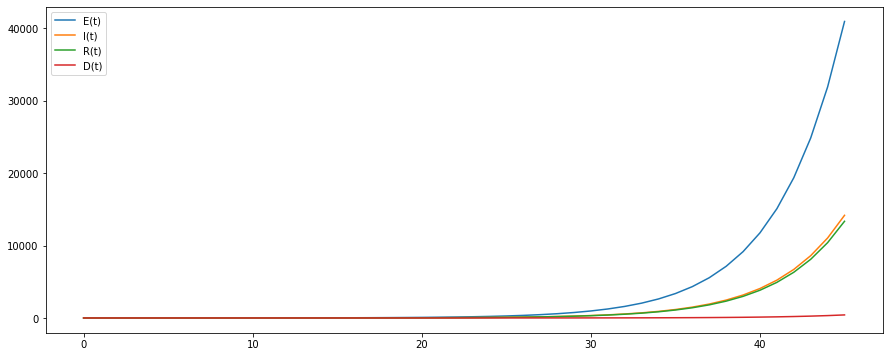

In [40]:
plot_train_example(X[2312])

### 3. Trening i selekcja modelu

In [72]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor


In [67]:
# X = np.load('X.npy')

In [68]:
# y = np.load('y.npy')

Reshape train data

### TODO: Czy skalujemy dane?

In [63]:
X =  X.reshape(X.shape[0],-1)

Split into train and test

In [66]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

10-krotna walidacja krzyżowa

In [69]:
kf = KFold(n_splits=10)

### TODO: Przetestować różne wysokości drzewa

In [75]:
scores_mse = []
for train_index, test_index in tqdm(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    regr = DecisionTreeRegressor(max_depth=5)
    regr.fit(X_train, y_train)
    preds = regr.predict(X_test)
    scores_mse.append((y_test - preds) ** 2)
    
scores_mse = np.array(scores_mse)

10it [01:00,  6.02s/it]


### MSE:

In [105]:
np.mean(scores_mse.reshape(10 * 7128, -1), axis=0)

array([0.0021662 , 0.0017534 , 0.00083095, 0.00128965, 0.00031632])

Wygląda na to, że uczy się dobrze.

### 4. Przetestowanie modelu na rzeczywistych danych

Dane o R, D, I są prawdziwe. Jak uzyskać E?

In [145]:
R = np.array([0, 0, 0, 1, 1, 1, 3, 45, 46, 50, 83, 149, 160, 276, 414, 523, 589, 622, 724, 1004, 1045, 1258, 1439, 1966, 2335, 2749, 2941, 4025, 4440, 5129, 6072, 7024, 7432, 8326, 9362, 10361, 10950, 12384, 13030, 14620, 15729, 16847, 18278, 19758, 20996, 21815]) # H_diagnosticati
D = np.array([0, 1, 2, 2, 5, 10, 12, 17, 21, 29, 34, 52, 79, 107, 148, 197, 233, 366, 463, 631, 827, 1016, 1266, 1441, 1809, 2158, 2503, 2978, 3405, 4032, 4825, 5476, 6077, 6820, 7503, 8165, 9134, 10023, 10779, 11591, 12428, 13155, 13915, 14681, 15362, 15887]) # E
I = np.array([3, 19, 77, 129, 213, 311, 385, 588, 821, 1049, 1577, 1835, 2263, 2706, 3296, 3916, 5061, 6387, 7985, 8514, 10590, 12839, 14955, 17750, 20603, 23073, 26062, 28710, 33190, 37860, 42681, 46638, 50418, 54030, 57521, 62013, 66414, 70065, 73880, 75528, 77635, 80572, 83049, 85388, 88274, 91246]) # D+R+T
E = 3*np.array([2,15, 27, 49, 91, 162, 221, 284, 412, 543, 798, 927, 1000, 1065, 1155, 1060, 1843, 2180, 2936, 2599, 3724, 5036, 6201, 7860, 9268, 10197, 11108, 12090, 14935, 19185, 22116, 23783, 26522, 28697, 30920, 33648, 36653, 39533, 42588, 43752, 45420, 48134, 50456, 52579, 55270, 58320]) #D
S = 60e6 - E

In [146]:
X_test = np.array([S,E,I,R,D])

### Plot real data

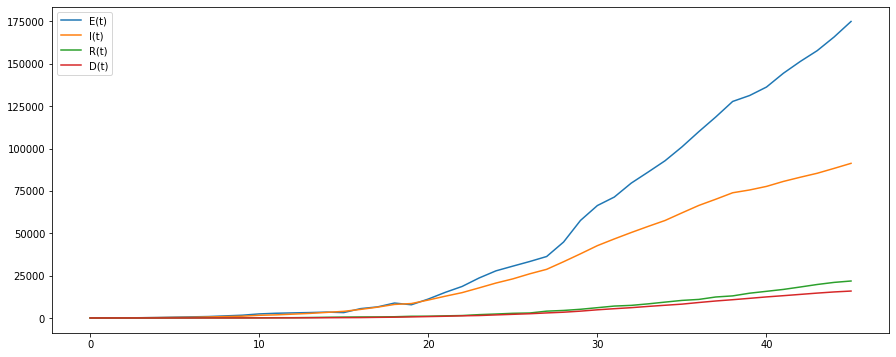

In [147]:
plot_train_example(X_test)

In [148]:
X_test = X_test.reshape(1, 5*46)

In [149]:
beta, gamma, delta, alpha, rho = regr.predict(X_test)[0]

In [150]:
t = np.linspace(0, 46, 46) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))

In [151]:
S_pred,E_pred,I_pred,R_pred,D_pred = ret.T

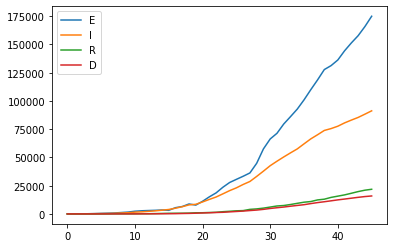

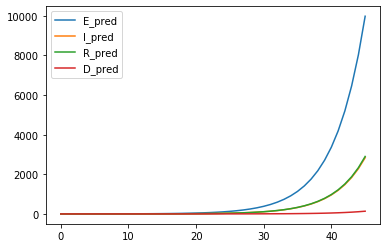

In [152]:
#plt.plot(S)
plt.plot(E, label='E')
plt.plot(I, label='I')
plt.plot(R, label='R')
plt.plot(D, label='D')
plt.legend()
plt.show()

plt.plot(E_pred, label='E_pred')
plt.plot(I_pred, label='I_pred')
plt.plot(R_pred, label='R_pred')
plt.plot(D_pred, label='D_pred')
plt.legend()
plt.show()

### Fajnie byłoby znaleźć dane z Diamond Princess

### Pouczymy chwilę bez E (i bez S, bo S zależy od E)

In [163]:
X = np.load('X_train.npy')

In [164]:
y = np.load('y_train.npy')

In [165]:
X = X[:, [2,3,4], :]

In [166]:
X.shape

(71280, 3, 46)

In [167]:
X = X.reshape(X.shape[0],-1)

In [168]:
kf = KFold(n_splits=10)

In [169]:
scores_mse = []
for train_index, test_index in tqdm(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    regr = DecisionTreeRegressor(max_depth=5)
    regr.fit(X_train, y_train)
    preds = regr.predict(X_test)
    scores_mse.append((y_test - preds) ** 2)
    
scores_mse = np.array(scores_mse)

10it [00:41,  4.20s/it]


In [170]:
np.mean(scores_mse.reshape(10 * 7128, -1), axis=0)

array([0.00967307, 0.00207546, 0.00024645, 0.00217767, 0.0003248 ])

### Błędy trochę większe, ale nie ma tragedii.

In [171]:
X_test = np.array([I,R,D])

In [172]:
X_test = X_test.reshape(1, 3*46)

In [173]:
beta, gamma, delta, alpha, rho = regr.predict(X_test)[0]

In [174]:
t = np.linspace(0, 46, 46) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))

In [175]:
S_pred,E_pred,I_pred,R_pred,D_pred = ret.T

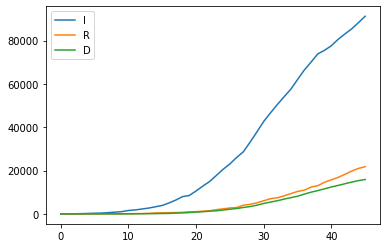

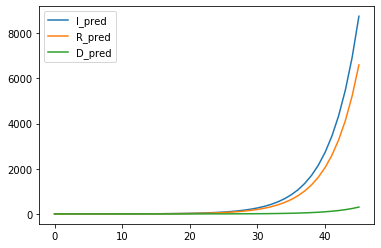

In [176]:
plt.plot(I, label='I')
plt.plot(R, label='R')
plt.plot(D, label='D')
plt.legend()
plt.show()

plt.plot(I_pred, label='I_pred')
plt.plot(R_pred, label='R_pred')
plt.plot(D_pred, label='D_pred')
plt.legend()
plt.show()

### Jedno zero za mało...